# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1zXvzr7Tn28gpAugZAj_CUybeuIQN164r?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import numpy as np
import time
import math
import os

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def get_data_loader(batch_size):
  transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
  all_data = datasets.ImageFolder(root = '/content/gdrive/MyDrive/APS360/Lab3_Gestures_Summer',transform=transform)

  #Based on my research, a common approach of 80% training, 10% validation,
  #and 10% testing data. Therefore, I split the data to be 80% training, 10% validation, and 10% testing
  train_ratio,val_ratio,test_ratio = 0.8,0.1,0.1

  train_size = int(len(all_data) * train_ratio)
  val_size = int(len(all_data) * val_ratio)
  test_size = len(all_data) - train_size - val_size

  #The way I split the data is using the function random_split,
  #which it is capable of split the data set into non-overlapping new datasets with the given lengths.
  #Furthermore, it is capable of spliting the remainder (if there are any) images/data randomly to the split.
  #The exact number of train, validation, and test set images are printed below.
  train_set, val_set, test_set = torch.utils.data.random_split(all_data, [train_size, val_size, test_size])

  print("The number of data in the training set: ", len(train_set))
  print("The number of data in the validation set: ", len(val_set))
  print("The number of data in the testing set: ", len(test_set))
  #There is no need for shuffling for val_loader and test_loader because we are using them to evaluate the model,
  #which it is better if they are consistent.
  #The shuffling in the train_loader introduces randomness which prevent adding biases or overfitting
  #in case the model learns the order of the data.

  #num_workers is set according to the number of CPU availble for use using the os module (os.cpu_count())
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

  return train_loader, val_loader, test_loader

In [ ]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

get_data_loader(1)

The number of data in the training set:  1775
The number of data in the validation set:  221
The number of data in the testing set:  223


(<torch.utils.data.dataloader.DataLoader at 0x7f593842f940>,
 <torch.utils.data.dataloader.DataLoader at 0x7f593842f820>)

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes, kernel_dim=[5,5,3]):
        super(Net, self).__init__()
        self.name = "Net"
        #Used 2 convolutional layers to ensure that the network has the capabilities
        #of handling large amount of data. Furthermore, the shared weighting of CNN
        #network helps with image as it reduces dimensionality while keeping all the information contained.

        #A max pooling layer was used to lowers the resolution of the image(s)
        #and to detect the objects regardless of location
        #Since it is RGB images, the in-channel should be 3.
        #It is then brought to higher dimension for further detections of the features.
        self.conv1 = nn.Conv2d(3, 5, kernel_dim[0])
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, kernel_dim[1])

        #stride of 2 -> downsampling for now using 1
        #input = 224, kernel dim 5*5*3, stride 1*1,
        #no padding since not much improtant info around the age of the data
        #self.output_dim =  (((((224 - kernel_dim[0])//2 +1) - kernel_dim[1])//2)+1 )
        self.output_dim = ((224 - kernel_dim[0] + 1) // 2 - kernel_dim[1] + 1) // 2

        #2 fully connected layers were used to compute the final probilities for the classification.
        #The number of units was chosen to ensure the complexity of model for computing the probilities.
        self.fc1 = nn.Linear((self.output_dim**2)*10, 30)
        self.fc2 = nn.Linear(30, num_classes)


    def forward(self, x):
        #The chosen activation function is relu which is commonly used in most cases for models.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*(self.output_dim**2))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_net(network, batch_size=512, learning_rate=0.001, num_epochs=10):

    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

    torch.manual_seed(100)

    train_loader, val_loader, test_loader = get_data_loader(batch_size)

    # The chosen loss function will be Binary Cross Entropy.
    # BCEWithLogitsLoss is capable of taking unnormalized output from
    # the neural network and scalar label.
    # Adam was chosen as optimizer as it is good for the stochastic gradient descent
    #and its abilities to deal with noisy data.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)


    train_acc = []
    val_acc = []
    losses = []
    iters = []
    n=0

    start_time = time.time()

    for epoch in range(num_epochs):
        batch_correct = 0
        batch_total = 0
        total_epoch = 0

        for imgs, labels in iter(train_loader):

            labels_one_hot = torch.zeros(labels.size(0), len(classes))
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)

            outputs = network(imgs)
            loss = criterion(outputs, labels_one_hot)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            n+=1

        train_epoch_acc = get_accuracy(network, train_loader)
        train_acc.append(train_epoch_acc)

        val_epoch_acc = get_accuracy(network, val_loader)
        val_acc.append(val_epoch_acc)

        print("Epoch {}: Train acc: {} Validation acc: {}".format(epoch + 1, train_epoch_acc, val_epoch_acc))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(network.name, batch_size, learning_rate, epoch)
        torch.save(network.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)

    return train_acc, val_acc, epochs


In [ ]:
net = Net(num_classes=len(classes))

train_net(net)

The number of data in the training set:  1775
The number of data in the validation set:  221
The number of data in the testing set:  223
Epoch 1: Train acc: 0.10929577464788733 Validation acc: 0.13122171945701358
Epoch 2: Train acc: 0.1104225352112676 Validation acc: 0.12217194570135746
Epoch 3: Train acc: 0.11492957746478873 Validation acc: 0.1085972850678733
Epoch 4: Train acc: 0.1504225352112676 Validation acc: 0.1493212669683258
Epoch 5: Train acc: 0.23380281690140844 Validation acc: 0.2579185520361991
Epoch 6: Train acc: 0.2647887323943662 Validation acc: 0.28054298642533937
Epoch 7: Train acc: 0.24338028169014084 Validation acc: 0.2895927601809955
Epoch 8: Train acc: 0.3256338028169014 Validation acc: 0.36199095022624433
Epoch 9: Train acc: 0.37408450704225354 Validation acc: 0.4343891402714932
Epoch 10: Train acc: 0.37126760563380284 Validation acc: 0.4479638009049774
Finished Training
Total time elapsed: 787.14 seconds


### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
def get_small_data_loader(batch_size):
  transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
  all_data = datasets.ImageFolder(root = '/content/gdrive/MyDrive/APS360/Lab3_Gestures_Summer',transform=transform)

  #Assume no need for testing data and only taking some small amount of data as train
  train_ratio,val_ratio,test_ratio = 0.01,0.01, 0.98

  train_size = int(len(all_data) * train_ratio)
  val_size = int(len(all_data) * val_ratio)
  test_size = len(all_data) - train_size - val_size

  train_set, val_set, test_set = torch.utils.data.random_split(all_data, [train_size, val_size,test_size])

  print("The number of data in the training set: ", len(train_set))
  print("The number of data in the validation set: ", len(val_set))
  print("The number of data in the test set: ", len(test_set))

  small_train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
  small_val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
  small_test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

  return small_train_loader, small_val_loader, small_test_loader



def small_train(network, batch_size=22, learning_rate=0.001, num_epochs=70):
  torch.manual_seed(10)
  small_train_loader, small_val_loader, small_test_loader = get_small_data_loader(batch_size)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)

  train_acc = []
  val_acc = []
  losses = []
  iters = []

  n=0

  start_time = time.time()

  for epoch in range(num_epochs):
      batch_correct = 0
      batch_total = 0
      total_epoch = 0

      for imgs, labels in iter(small_train_loader):

          labels_one_hot = torch.zeros(labels.size(0), len(classes))
          labels_one_hot.scatter_(1, labels.view(-1, 1), 1)

          outputs = network(imgs)
          loss = criterion(outputs, labels_one_hot)

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          n+=1

      train_epoch_acc = get_accuracy(network, small_train_loader)
      train_acc.append(train_epoch_acc)

      val_epoch_acc = get_accuracy(network, small_val_loader)
      val_acc.append(val_epoch_acc)

      print("Epoch {}: Train acc: {} Validation acc: {}".format(epoch + 1, train_epoch_acc, val_epoch_acc))

      model_path = get_model_name(network.name, batch_size, learning_rate, epoch)
      torch.save(network.state_dict(), model_path)

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
  np.savetxt("{}_val_acc.csv".format(model_path), val_acc)


net = Net(num_classes=len(classes))
small_train(net)


The number of data in the training set:  22
The number of data in the validation set:  22
The number of data in the test set:  2175
Epoch 1: Train acc: 0.09090909090909091 Validation acc: 0.09090909090909091
Epoch 2: Train acc: 0.09090909090909091 Validation acc: 0.09090909090909091
Epoch 3: Train acc: 0.22727272727272727 Validation acc: 0.045454545454545456
Epoch 4: Train acc: 0.22727272727272727 Validation acc: 0.045454545454545456
Epoch 5: Train acc: 0.22727272727272727 Validation acc: 0.045454545454545456
Epoch 6: Train acc: 0.45454545454545453 Validation acc: 0.09090909090909091
Epoch 7: Train acc: 0.3181818181818182 Validation acc: 0.09090909090909091
Epoch 8: Train acc: 0.3181818181818182 Validation acc: 0.09090909090909091
Epoch 9: Train acc: 0.3181818181818182 Validation acc: 0.09090909090909091
Epoch 10: Train acc: 0.3181818181818182 Validation acc: 0.09090909090909091
Epoch 11: Train acc: 0.3181818181818182 Validation acc: 0.09090909090909091
Epoch 12: Train acc: 0.318181818

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
#I think batch size, learning rate, and the kernel size should be worth tuning.
#The default batch_size = 512, learning_rate =0.001, and kernel_dim = [5,5,3]

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

The number of data in the training set:  1775
The number of data in the validation set:  221
The number of data in the testing set:  223
Epoch 1: Train acc: 0.1104225352112676 Validation acc: 0.12217194570135746
Epoch 2: Train acc: 0.17859154929577464 Validation acc: 0.18552036199095023
Epoch 3: Train acc: 0.10929577464788733 Validation acc: 0.12669683257918551
Epoch 4: Train acc: 0.14535211267605633 Validation acc: 0.11312217194570136
Epoch 5: Train acc: 0.15267605633802817 Validation acc: 0.14027149321266968
Epoch 6: Train acc: 0.2608450704225352 Validation acc: 0.2669683257918552
Epoch 7: Train acc: 0.24169014084507043 Validation acc: 0.23529411764705882
Epoch 8: Train acc: 0.3667605633802817 Validation acc: 0.35294117647058826
Epoch 9: Train acc: 0.5256338028169014 Validation acc: 0.5158371040723982
Epoch 10: Train acc: 0.5611267605633803 Validation acc: 0.5701357466063348
Finished Training
Total time elapsed: 754.33 seconds


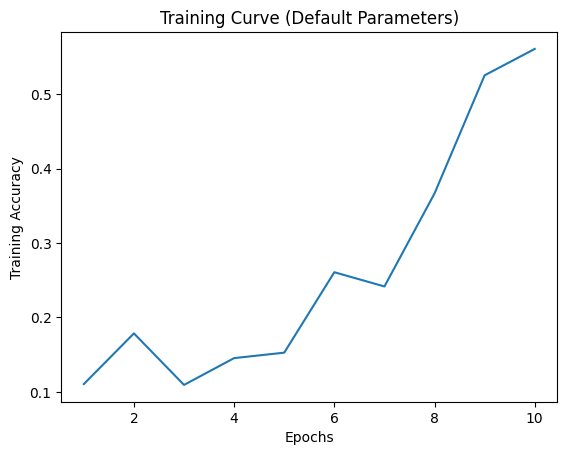

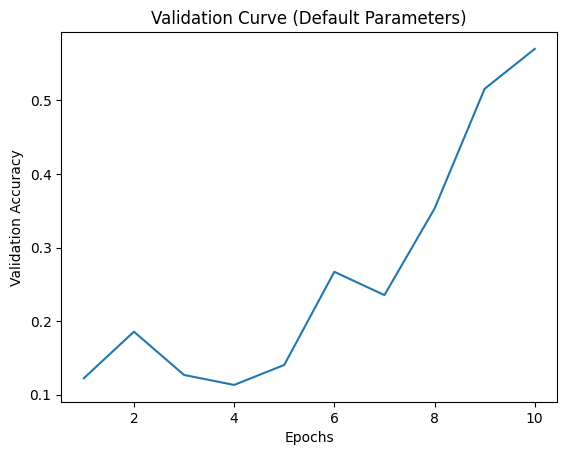

In [ ]:
#Changed batch size to 256, learning rate and kernel dimension remain unchanged
net=Net(num_classes=len(classes))
train_acc, val_acc, epochs = train_net(net,batch_size=256)

plt.plot(epochs, train_acc)
plt.title("Training Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

The number of data in the training set:  1775
The number of data in the validation set:  221
The number of data in the testing set:  223
Epoch 1: Train acc: 0.11267605633802817 Validation acc: 0.11312217194570136
Epoch 2: Train acc: 0.11267605633802817 Validation acc: 0.11312217194570136
Epoch 3: Train acc: 0.1104225352112676 Validation acc: 0.12217194570135746
Epoch 4: Train acc: 0.1104225352112676 Validation acc: 0.12217194570135746
Epoch 5: Train acc: 0.1104225352112676 Validation acc: 0.12217194570135746
Epoch 6: Train acc: 0.14816901408450706 Validation acc: 0.16289592760180996
Epoch 7: Train acc: 0.1104225352112676 Validation acc: 0.12217194570135746
Epoch 8: Train acc: 0.1104225352112676 Validation acc: 0.12217194570135746
Epoch 9: Train acc: 0.14985915492957746 Validation acc: 0.15384615384615385
Epoch 10: Train acc: 0.12056338028169014 Validation acc: 0.10407239819004525
Finished Training
Total time elapsed: 712.65 seconds


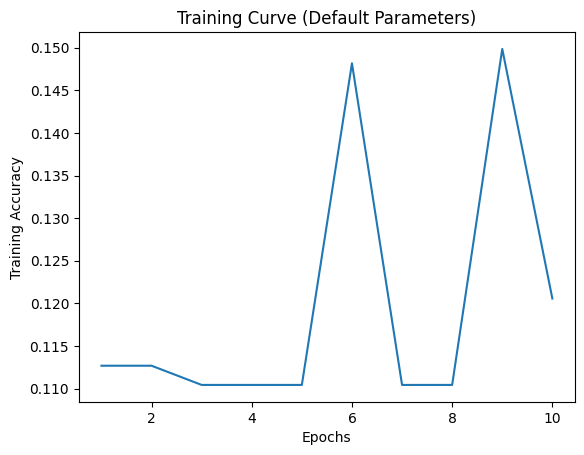

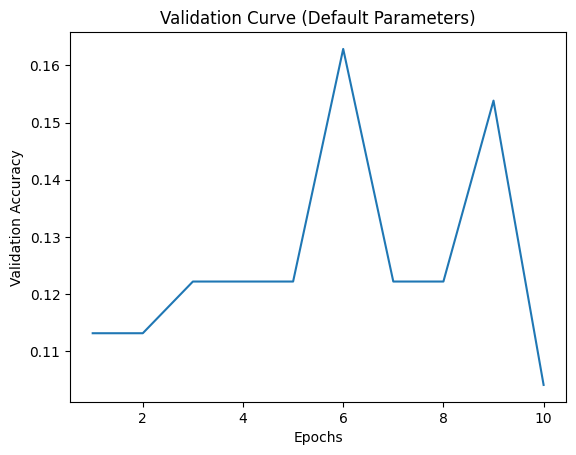

In [ ]:
#Since the batch size of 256 showed good result,
#I decided to keep this and modify the learning rate to be smaller and
#examine the effect of that. The kernel_dim remain unchanged as default.
net=Net(num_classes=len(classes))
train_acc, val_acc, epochs = train_net(net, batch_size=256, learning_rate=0.0001)

plt.plot(epochs, train_acc)
plt.title("Training Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

The number of data in the training set:  1775
The number of data in the validation set:  221
The number of data in the testing set:  223
Epoch 1: Train acc: 0.10929577464788733 Validation acc: 0.13122171945701358
Epoch 2: Train acc: 0.11549295774647887 Validation acc: 0.12217194570135746
Epoch 3: Train acc: 0.11774647887323944 Validation acc: 0.12217194570135746
Epoch 4: Train acc: 0.19774647887323943 Validation acc: 0.248868778280543
Epoch 5: Train acc: 0.13183098591549297 Validation acc: 0.13574660633484162
Epoch 6: Train acc: 0.1323943661971831 Validation acc: 0.15384615384615385
Epoch 7: Train acc: 0.29859154929577464 Validation acc: 0.3212669683257919
Epoch 8: Train acc: 0.30028169014084505 Validation acc: 0.3393665158371041
Epoch 9: Train acc: 0.28112676056338026 Validation acc: 0.3031674208144796
Epoch 10: Train acc: 0.3419718309859155 Validation acc: 0.3665158371040724
Finished Training
Total time elapsed: 580.72 seconds


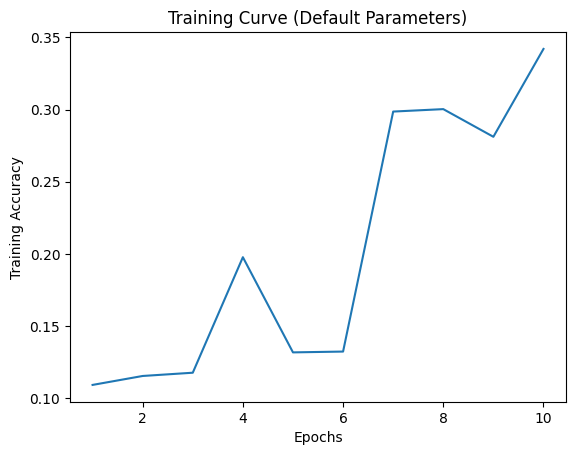

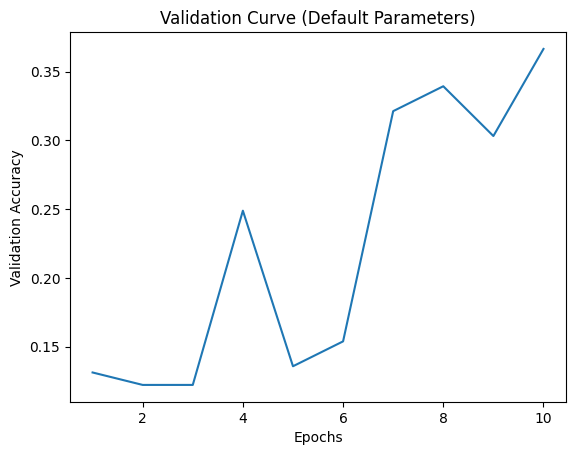

In [ ]:
#Keeping the positive result of batch_size =256, I tuned the kernel_dim to be 3*3
#to see if this would provide better performance with higher complexity (with higher number of parameters)
net = Net(len(classes), kernel_dim=[3, 3, 3])
train_acc, val_acc, epochs = train_net(net, batch_size=256)

plt.plot(epochs, train_acc)
plt.title("Training Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

The number of data in the training set:  1775
The number of data in the validation set:  221
The number of data in the testing set:  223
Epoch 1: Train acc: 0.10535211267605633 Validation acc: 0.09049773755656108
Epoch 2: Train acc: 0.10535211267605633 Validation acc: 0.09049773755656108
Epoch 3: Train acc: 0.10535211267605633 Validation acc: 0.09049773755656108
Epoch 4: Train acc: 0.11380281690140845 Validation acc: 0.09954751131221719
Epoch 5: Train acc: 0.11380281690140845 Validation acc: 0.09954751131221719
Epoch 6: Train acc: 0.11380281690140845 Validation acc: 0.09954751131221719
Epoch 7: Train acc: 0.1104225352112676 Validation acc: 0.12217194570135746
Epoch 8: Train acc: 0.11549295774647887 Validation acc: 0.12217194570135746
Epoch 9: Train acc: 0.11549295774647887 Validation acc: 0.12217194570135746
Epoch 10: Train acc: 0.11549295774647887 Validation acc: 0.12217194570135746
Finished Training
Total time elapsed: 931.34 seconds


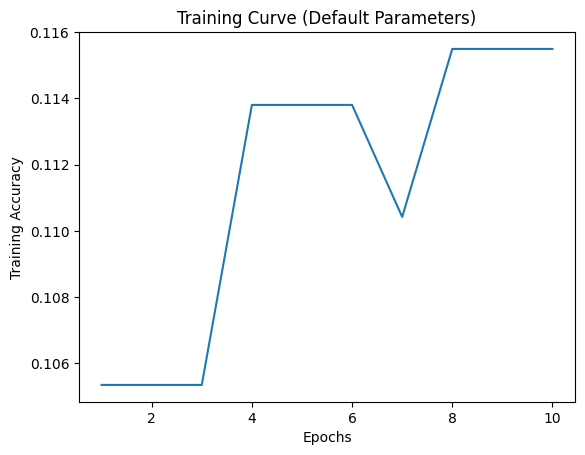

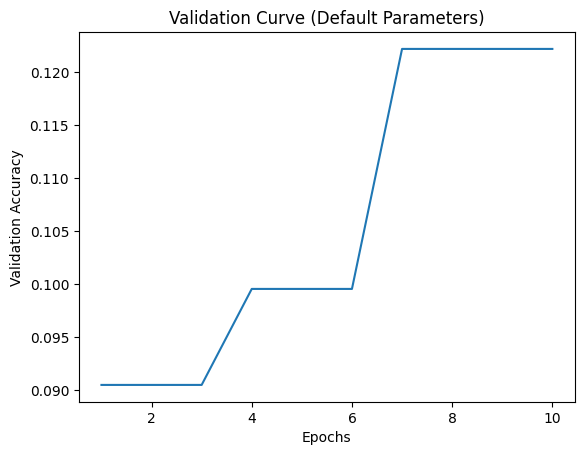

In [ ]:
#Since learning rate change did not show much of improvement,
#I tried to increase the kernel size along with the good batch size of 256 to see
#if this could improve the model's performance.
net = Net(len(classes), kernel_dim=[7, 7, 3])
train_acc, val_acc, epochs = train_net(net, batch_size=256,learning_rate=0.1)

plt.plot(epochs, train_acc)
plt.title("Training Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
# The best model was the first model, with batch_size = 256, learning_rate=0.001,
# and kernel_dim=[5,5,3] and the number of epochs trained = 10.

#I consider this to be the best model as out of all the options this was the one
#that provided the highest training accuracy of approximately 56.1% and
#validation accuracy of 57% which are both relatively high compared to the other models trained above
#with the same number of epochs and hyperparameters tuning.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
net = Net(num_classes=9)

train_loader, val_loader, test_loader = get_data_loader(64)

get_accuracy(net, test_loader)

The number of data in the training set:  1775
The number of data in the validation set:  221
The number of data in the testing set:  223


0.10762331838565023

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)

NameError: ignored

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
alexnet = models.alexnet(pretrained=True)

train_loader, val_loader, test_loader = get_data_loader(1)

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

train_path = "/content/gdrive/MyDrive/APS360/Lab3_Alex_Features/Train_Features"
val_path = "/content/gdrive/MyDrive/APS360/Lab3_Alex_Features/Val_Features"
test_path = "/content/gdrive/MyDrive/APS360/Lab3_Alex_Features/Test_Features"

i = 0
for input, label in train_loader:
  features_tensor = torch.from_numpy(alexnet.features(input).detach().numpy())

  train_folder = train_path + "/"+ str(classes[label])
  if not os.path.isdir(train_folder):
    os.mkdir(train_folder)

  torch.save(features_tensor.squeeze(0), train_folder + '/' + str(i) + '.tensor')

  i += 1

j = 0
for input, label in val_loader:
  features_tensor = torch.from_numpy(alexnet.features(input).detach().numpy())

  val_folder = val_path + "/"+ str(classes[label])
  if not os.path.isdir(val_folder):
    os.mkdir(val_folder)

  torch.save(features_tensor.squeeze(0), val_folder + '/' + str(j) + '.tensor')

  j += 1

k = 0
for input, label in train_loader:
  features_tensor = torch.from_numpy(alexnet.features(input).detach().numpy())

  test_folder = test_path + "/"+ str(classes[label])
  if not os.path.isdir(test_folder):
    os.mkdir(test_folder)

  torch.save(features_tensor.squeeze(0), test_folder + '/' + str(k) + '.tensor')

  k += 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 98.6MB/s]


The number of data in the training set:  1775
The number of data in the validation set:  221
The number of data in the testing set:  223


### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
class CNNclassifier(nn.Module):
    def __init__(self, num_classes, kernel_dim=[3,3]):
      super(CNNclassifier, self).__init__()
      self.name = "CNNclassifier"
      self.conv1 = nn.Conv2d(256, 50,kernel_dim[0])
      self.pool = nn.MaxPool2d(2, 2)

      #The tensor from the dataloader has input of 6 which is the dimension used for calculation.
      self.output_dim =  ((6 - kernel_dim[0])//2 +1)


      self.fc1 = nn.Linear((self.output_dim**2)*50, 30)
      self.fc2 = nn.Linear(30, num_classes)


    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = x.view(-1, 50*(self.output_dim**2))
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      return x


# features = ... load precomputed alexnet.features(img) ...
#output = (features)
#prob = F.softmax(output)

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
def train_alex_net(network, batch_size=512, learning_rate=0.001, num_epochs=10):

    # Train a classifier on cats vs dogs
    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(100)

    #load the features data
    train_features_path = datasets.DatasetFolder("/content/gdrive/MyDrive/APS360/Lab3_Alex_Features/Train_Features", loader=torch.load, extensions=('.tensor'))
    val_features_path = datasets.DatasetFolder("/content/gdrive/My Drive/APS360/Lab3_Alex_Features/Val_Features", loader=torch.load, extensions=('.tensor'))
    test_features_path = datasets.DatasetFolder("/content/gdrive/My Drive/APS360/Lab3_Alex_Features/Test_Features", loader=torch.load, extensions=('.tensor'))

    train_feature_loader = torch.utils.data.DataLoader(train_features_path, batch_size=64,
                                           num_workers=2, shuffle=True)
    val_feature_loader = torch.utils.data.DataLoader(val_features_path, batch_size=64,
                                           num_workers=2, shuffle=True)
    test_feature_loader = torch.utils.data.DataLoader(test_features_path, batch_size=64,
                                           num_workers=2, shuffle=True)

    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be Adam
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)

    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = []
    val_acc = []
    losses = []
    iters = []

    n=0

    start_time = time.time()

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        batch_correct = 0
        batch_total = 0
        total_epoch = 0

        for imgs, labels in iter(train_feature_loader):
            labels_one_hot = torch.zeros(labels.size(0), len(classes))
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)  # Convert labels to one-hot encoding

            outputs = network(imgs)  # forward pass
            loss = criterion(outputs, labels_one_hot)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()

            n += 1

        train_epoch_acc = get_accuracy(network, train_feature_loader)
        train_acc.append(train_epoch_acc)

        val_epoch_acc = get_accuracy(network, val_feature_loader)
        val_acc.append(val_epoch_acc)

        print("Epoch {}: Train acc: {} Validation acc: {}".format(epoch + 1, train_epoch_acc, val_epoch_acc))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(network.name, batch_size, learning_rate, epoch)
        torch.save(network.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))


    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)

    return train_acc, val_acc, epochs

#tensor = torch.from_numpy(tensor.detach().numpy())
alex_net = CNNclassifier(num_classes=9)

train_acc, val_acc, epochs = train_alex_net(alex_net)

Epoch 1: Train acc: 0.5340845070422535 Validation acc: 0.5113122171945701
Epoch 2: Train acc: 0.8005633802816902 Validation acc: 0.7782805429864253
Epoch 3: Train acc: 0.856338028169014 Validation acc: 0.8099547511312217
Epoch 4: Train acc: 0.8873239436619719 Validation acc: 0.8506787330316742
Epoch 5: Train acc: 0.9194366197183098 Validation acc: 0.8823529411764706
Epoch 6: Train acc: 0.9402816901408451 Validation acc: 0.9095022624434389
Epoch 7: Train acc: 0.9622535211267605 Validation acc: 0.9321266968325792
Epoch 8: Train acc: 0.9752112676056338 Validation acc: 0.9366515837104072
Epoch 9: Train acc: 0.979718309859155 Validation acc: 0.9457013574660633
Epoch 10: Train acc: 0.979718309859155 Validation acc: 0.9457013574660633
Finished Training
Total time elapsed: 87.50 seconds


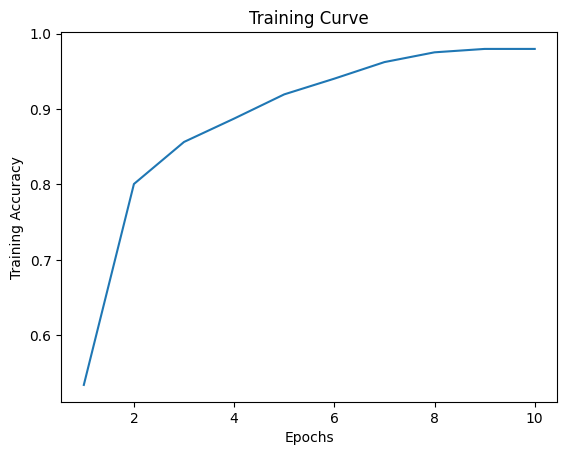

Text(0, 0.5, 'Validation Accuracy')

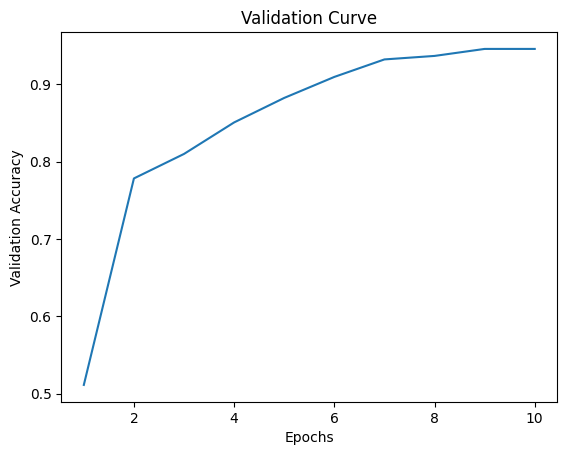

In [ ]:
plt.plot(epochs, train_acc)
plt.title("Training Curve")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(epochs, val_acc)
plt.title("Validation Curve")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
alex_net = CNNclassifier(num_classes=9)

model_path = get_model_name(alex_net.name, batch_size=512, learning_rate=0.001, epoch=9)
state = torch.load(model_path)
alex_net.load_state_dict(state)

test_features_path = datasets.DatasetFolder("/content/gdrive/My Drive/APS360/Lab3_Alex_Features/Test_Features", loader=torch.load, extensions=('.tensor'))
test_feature_loader = torch.utils.data.DataLoader(test_features_path, batch_size=64, num_workers=2, shuffle=True)

get_accuracy(alex_net, test_feature_loader)

#The test accuracy of the best model is 97.9% which compared to the best test accuracy of Part 3d, which was 10.8%
#which as shown this is much better compared to a model built from scartch.
#This demonstrates the importance of transfer learning as alex_net was much more complex and therefore
#having better capabilities in solving these problems.

0.979718309859155

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
def alex_small_data_loader(batch_size):
  transform = transforms.Compose([transforms.ToTensor()])
  all_data = datasets.ImageFolder(root = '/content/gdrive/MyDrive/APS360/Lab3_Gestures_Summer',transform=transform)

  #Assume no need for testing data and only taking some small amount of data as train
  train_ratio,val_ratio,test_ratio = 0.01,0.01, 0.98

  train_size = int(len(all_data) * train_ratio)
  val_size = int(len(all_data) * val_ratio)
  test_size = len(all_data) - train_size - val_size

  train_set, val_set, test_set = torch.utils.data.random_split(all_data, [train_size, val_size,test_size])

  print("The number of data in the training set: ", len(train_set))
  print("The number of data in the validation set: ", len(val_set))
  print("The number of data in the test set: ", len(test_set))

  small_train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
  small_val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
  small_test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

  return small_train_loader, small_val_loader, small_test_loader

In [ ]:
alex_net = CNNclassifier(num_classes=9)

model_path = get_model_name(alex_net.name, batch_size=512, learning_rate=0.001, epoch=9)
state = torch.load(model_path)
alex_net.load_state_dict(state)


train_loader, val_loader, test_loader = alex_small_data_loader(50)

get_accuracy(alex_net, test_loader)

#I tried to make a new data_loader to fix this, however, the error still existed because of the tensor size.
#Overall, the model using transfer learning should be performing well based on the previous test data result.

The number of data in the training set:  22
The number of data in the validation set:  22
The number of data in the test set:  2175


RuntimeError: ignored